# Lista 2 - Ilościowe dopasowanie par sekwencji

## Pseudokod

```
Zdefiniuj:
	seq1: str
	seq2: str
	gap: int
	bonus: int
	penalty: int

n = len(seq1)
m = len(seq2)

Zadeklaruj:
	score_matrix[n + 1][m + 1] <- 0
	traceback[n + 1][m + 1] <- 0

Dla i = 0 do n:
	score_matrix[i][0] = i * gap

Dla j = 0 do m:
	score_matrix[0][j] = j * gap

Dla i = 1 do n:
	Dla j = 1 do m:
		top = score_matrix[i][j - 1] + gap
		left = score_matrix[i - 1][j] + gap
		diag = score_matrix[i - j][j - 1] + seq1[i] == seq2[i] ? bonus : penalty
		score_matrix[i][j] = max(top, left, diag)

		Jeżeli score_matrix[i][j] == diag:
			traceback[i][j] = 0
		W innym wypadku jeżeli score_matrix[i][j] == top:
			traceback[i][j] = 1
		W innym wypadku:
			traceback[i][j] = 2

k = n
l = m
a1 = ""
a2 = ""

Tak długo jak k > 0 lub l > 0:
	Jeżeli traceback[k][l] == 0:
		a1 = seq1[k - 1] + a1
        a2 = seq2[l - 1] + a2
        k -= 1
        l -= 1
    W innym wypadku jeżeli traceback[k][l] == 1:
		a1 = seq1[k - 1] + a1
        k -= 1
	W innym wypadku:
		a2 = seq2[k - 1] + a2
        l -= 1

Zwróć a1, a2


```


## Program

### Importy

In [1]:
import typing
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

### Wczytanie sekwencji

In [2]:
def read_sequence(mode: str = "input", filepath: str = None, seq: str = None) -> tuple[str, str]:
    """
    Modes: 'fasta' - reads file, 'input' - takes input from user, 'arg' - returns sequence given as an argument
    """
    data, name = str(), "undefined"
    if mode == "fasta":
        print(f"Reading file {filepath}...")
        try:
            with open(filepath, "r") as f:
                data = str()
                for l in f.readlines():
                    if not l.startswith(">"):
                        data += l
                    else:
                        name = l.split("|")[2]
                        name = name[:name.find("OS=")]
                        print(name)
        except Exception as e:
            print("File reading error")
    elif mode == "arg":
        data = seq
    elif mode == "input":
        data = input("Type in the desired sequence: ")
    else:
        print("Unknown option")
    data = data.replace("\n", "")
    for aa in data:
        if aa not in "ARNDCQEGHILKMFPSTWYV":
            raise Exception("Non-aminoacid found in sequence")
    return data, name

### Algorytm oceniania Needlemana-Wunscha

In [3]:
def needleman_wunsch(seq1: str, seq2: str, bonus: float, pen: float, gap: float):
    scoring_matrix = np.zeros((len(seq1) + 1, len(seq2) + 1))
    traceback_matrix = np.zeros((len(seq1) + 1, len(seq2) + 1))

    for i in range(len(seq1) + 1):
        scoring_matrix[i][0] = i * gap

    for j in range(len(seq2) + 1):
        scoring_matrix[0][j] = j * gap

    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            # diag, up, left
            opts = [scoring_matrix[i - 1][j - 1] + bonus if seq1[i - 1] == seq2[j - 1] else scoring_matrix[i - 1][j - 1] + pen, scoring_matrix[i - 1][j] + gap, scoring_matrix[i][j - 1] + gap]
            scoring_matrix[i][j] = max(opts)
            traceback_matrix[i][j] = opts.index(scoring_matrix[i][j])

    return scoring_matrix, traceback_matrix, scoring_matrix[len(seq1)][len(seq2)]


### Traceback

In [4]:
def nw_traceback(seq1: str, seq2: str, traceback: np.ndarray):
    best_alignment = list()
    align1, align2 = str(), str()
    i, j = np.shape(traceback)[0] - 1, np.shape(traceback)[1] - 1
    while i > 0 or j > 0:
        best_alignment.append((j + 0.5, i - 0.5))

        if traceback[i][j] == 0:
            align1 = seq1[i - 1] + align1
            align2 = seq2[j - 1] + align2
            i -= 1
            j -= 1
        elif traceback[i][j] == 1:
            align1 = seq1[i - 1] + align1
            align2 = "-" + align2
            i -= 1
        else:
            align1 = "-" + align1
            align2 = seq2[j-1] + align2
            j -= 1

    return align1, align2, best_alignment

### Algorytm Smitha-Watermana

In [5]:
def smith_waterman(seq1: str, seq2: str, bonus: float, pen: float, gap: float):
    scoring_matrix = np.zeros((len(seq1) + 1, len(seq2) + 1))
    traceback_matrix = np.zeros((len(seq1) + 1, len(seq2) + 1))

    max_score, max_i, max_j = 0, 0, 0

    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            # diag, up, left
            opts = [scoring_matrix[i - 1][j - 1] + bonus if seq1[i - 1] == seq2[j - 1] else scoring_matrix[i - 1][j - 1] + pen, scoring_matrix[i - 1][j] + gap, scoring_matrix[i][j - 1] + gap, 0]
            scoring_matrix[i][j] = max(opts)
            traceback_matrix[i][j] = opts.index(scoring_matrix[i][j])

            if scoring_matrix[i][j] > max_score:
                max_score = scoring_matrix[i][j]
                max_i, max_j = i, j

    return scoring_matrix, traceback_matrix, max_i, max_j, max_score

In [6]:
def sw_traceback(seq1: str, seq2: str, score: np.ndarray, traceback: np.ndarray, max_i: int, max_j: int):
    best_alignment = list()
    align1, align2 = str(), str()
    i, j = max_i, max_j
    while i > 0 and j > 0 and score[i][j] > 0:
        best_alignment.append((j + 0.5, i - 0.5))
        if traceback[i][j] == 0:
            align1 = seq1[i - 1] + align1
            align2 = seq2[j - 1] + align2
            i -= 1
            j -= 1
        elif traceback[i][j] == 1:
            align1 = seq1[i - 1] + align1
            align2 = "-" + align2
            i -= 1
        elif traceback[i][j] == 2:
            align1 = "-" + align1
            align2 = seq2[j-1] + align2
            j -= 1
        else:
            break


    return align1, align2, best_alignment

### Przetwarzanie wyniku

In [7]:
def process_score(align1: str, align2: str):
    assert len(align1) == len(align2)
    matches, breaks = 0, 0
    for i in range(len(align1)):
        if align1[i] == "-" or align2[i] == "-":
            matches -= 1
            breaks += 1
        elif align1[i] == align2[i]:
            matches += 1

    return matches, breaks, f"Matches: {(matches / len(align1) * 100):.2f}%", f"Breaks: {(breaks / len(align1) * 100):.2f}%"

In [8]:
def process_score_local(align1: str, align2: str):
    assert len(align1) == len(align2)
    matches = 0
    for i in range(len(align1)):
        if align1[i] == align2[i]:
            matches += 1
    return matches

### Wyświetlanie drogi dopasowania

In [9]:
def plot_alignment(score: np.ndarray, ba: list[tuple[float, float]], n1: str, n2: str, mode: str):
    if mode == "global":
        cmap = sns.color_palette("viridis", as_cmap=True)
        color = "navy"
    else:
        cmap = sns.color_palette("magma", as_cmap=True)
        color = "lime"
    fig, ax = plt.subplots()
    sns.heatmap(score, ax=ax, cmap=cmap)
    ax.plot(*zip(*ba), color=color)
    plt.ylabel(n1)
    plt.xlabel(n2)
    plt.title(f"global alignment")
    plt.show()

### Zapis do pliku

In [10]:
def save_to_file(filename: str, *args):
    with open(filename, "w") as f:
        for arg in args:
            try:
                line = str(arg)
                if type(arg) == "<class 'dict'>":
                    line = line.replace("{", "").replace("}", "").replace(", ", ",\n")
            except Exception:
                pass

            f.write(line + "\n")

    print(f"File {filename} saved!")

### Funkcje uruchomieniowe

In [11]:
def run(data: dict):
    """
    Dict data defined as:
        type: str -> 'global' or 'local'
        mode1: str -> 'fasta', 'input' or 'arg', defines mode of aquisition of first sequence
        seq1: str -> dependent on mode, file path if fasta, sequence if arg or empty if input
        mode2: str -> 'fasta', 'input' or 'arg', defines mode of aquisition of second sequence
        seq2: str -> dependent on mode, file path if fasta, sequence if arg or empty if input
        bonus: float -> score bonus for matching aminoacids
        pen: float -> score penalty for not matching aminoacids (negative)
        gap: float -> score penalty for creating a gap (negative)
        save_data: boolean -> true to save the data to *.txt file
        filename: str -> name of file to save the data to
    """
    if data.get("type", None) == None or data.get("mode1", None) == None or data.get("seq1", None) == None or data.get("mode2", None) == None or data.get("seq2", None) == None:
        print("Wrong dict format")
        return

    d1, n1 = read_sequence(mode=data["mode1"], seq=data["seq1"], filepath=data["seq1"])
    d2, n2 = read_sequence(mode=data["mode2"], seq=data["seq2"], filepath=data["seq2"])

    if data["type"].lower() == "global":
        if data.get("bonus", None) == None or data.get("pen", None) == None or data.get("gap", None) == None:
            bonus, pen, gap = 1, 0, -1
        else:
            bonus, pen, gap = data["bonus"], data["pen"], data["gap"]
        S, T, ms = needleman_wunsch(d1, d2, bonus, pen, gap)
        a1, a2, ba = nw_traceback(d1, d2, T)
        scoring = process_score(a1, a2)
        match_score = scoring[0]

        print("GLOBAL ALIGNMENT\n================\n")
        print(f"Sequence 1: {d1}")
        print(f"Sequence 2: {d2}")
        print(f"{bonus=} {gap=} {pen=}")
        print()
        print("Scoring matrix")
        print()
        print(S)
        print()
        print("Traceback matrix")
        print()
        print(T)
        print()
        print("Alignment")
        print()
        print(a1)
        print(a2)
        print(f"Score: {match_score}")
        print(scoring[2])
        print(scoring[3])
        print()

        if data.get("save_data", False) is True:
            save_to_file(f"global-{datetime.timestamp(datetime.now())}.txt", "GLOBAL ALIGNMENT", data, "\n\n", "scoring matrix", S,"traceback matrix", T, a1, a2, f"Score: {match_score}\n", scoring[2], scoring[3])
        plot_alignment(S, ba, n1, n2, "global")
    elif data["type"].lower() == "local":
        if data.get("bonus", None) == None or data.get("pen", None) == None or data.get("gap", None) == None:
            bonus, pen, gap = 1, -0.5, -1
        else:
            bonus, pen, gap = data["bonus"], data["pen"], data["gap"]
        S, T, i, j, ms = smith_waterman(d1, d2, bonus, pen, gap)
        a1, a2, ba = sw_traceback(d1, d2, S, T, i, j)

        print("LOCAL ALIGNMENT\n================\n")
        print(f"Sequence 1: {d1}")
        print(f"Sequence 2: {d2}")
        print(f"{bonus=} {gap=} {pen=}")
        print()
        print("Scoring matrix")
        print()
        print(S)
        print()
        print("Traceback matrix")
        print()
        print(T)
        print()
        print("Alignment")
        print()
        print(a1)
        print(a2)
        print(f"Score: {process_score_local(a1, a2)}")

        if data.get("save_data", False) is True:
            save_to_file(f"local-{datetime.timestamp(datetime.now())}.txt", "LOCA ALIGNMENT", data, "\n\n", "scoring matrix", S,"traceback matrix", T, a1, a2, f"Score: {len(a1)}")
        plot_alignment(S, ba, n1, n2, "local")
    else:
        print("Wrong type specified")






# Wykonanie programu

Reading file /content/drive/MyDrive/P02091.fasta...
HBB1_RAT Hemoglobin subunit beta-1 
Reading file /content/drive/MyDrive/A0PK11.fasta...
CLRN2_HUMAN Clarin-2 
GLOBAL ALIGNMENT

Sequence 1: MVHLTDAEKAAVNGLWGKVNPDDVGGEALGRLLVVYPWTQRYFDSFGDLSSASAIMGNPKVKAHGKKVINAFNDGLKHLDNLKGTFAHLSELHCDKLHVDPENFRLLGNMIVIVLGHHLGKEFTPCAQAAFQKVVAGVASALAHKYH
Sequence 2: MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDLVNATDRELVKFIGDIYYGLFRGCKVRQCGLGGRQSQFTIFPHLVKELNAGLHVMILLLLFLALALALVSMGFAILNMIQVPYRAVSGPGGICLWNVLAGGVVALAIASFVAAVKFHDLTERIANFQEKLFQFVVVEEQYEESFWICVASASAHAANLVVVAISQIPLPEIKTKIEEATVTAEDILY
bonus=1 gap=-1 pen=0

Scoring matrix

[[   0.   -1.   -2. ... -230. -231. -232.]
 [  -1.    1.    0. ... -228. -229. -230.]
 [  -2.    0.    1. ... -226. -227. -228.]
 ...
 [-145. -143. -141. ...  -36.  -37.  -38.]
 [-146. -144. -142. ...  -35.  -36.  -36.]
 [-147. -145. -143. ...  -34.  -35.  -36.]]

Traceback matrix

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 2. 2. 2.]
 [0. 1. 0. ... 2. 2. 2.]
 ...
 [0. 1. 1. ...

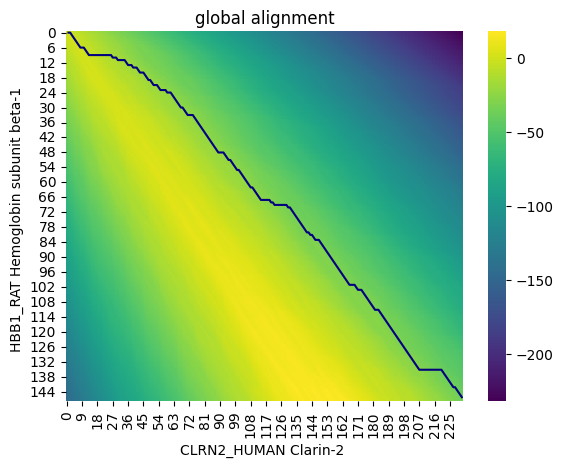

In [12]:
run({"type": "global", "mode1": "fasta", "seq1": "/content/drive/MyDrive/P02091.fasta", "mode2": "fasta", "seq2": "/content/drive/MyDrive/A0PK11.fasta", "bonus": 1, "pen": 0, "gap": -1, "save_data": True, "filename": "test.txt"})

Reading file /content/drive/MyDrive/P02091.fasta...
HBB1_RAT Hemoglobin subunit beta-1 
Reading file /content/drive/MyDrive/A0PK11.fasta...
CLRN2_HUMAN Clarin-2 
LOCAL ALIGNMENT

Sequence 1: MVHLTDAEKAAVNGLWGKVNPDDVGGEALGRLLVVYPWTQRYFDSFGDLSSASAIMGNPKVKAHGKKVINAFNDGLKHLDNLKGTFAHLSELHCDKLHVDPENFRLLGNMIVIVLGHHLGKEFTPCAQAAFQKVVAGVASALAHKYH
Sequence 2: MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDLVNATDRELVKFIGDIYYGLFRGCKVRQCGLGGRQSQFTIFPHLVKELNAGLHVMILLLLFLALALALVSMGFAILNMIQVPYRAVSGPGGICLWNVLAGGVVALAIASFVAAVKFHDLTERIANFQEKLFQFVVVEEQYEESFWICVASASAHAANLVVVAISQIPLPEIKTKIEEATVTAEDILY
bonus=1 gap=-1 pen=-0.5

Scoring matrix

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  1.  0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  1. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

Traceback matrix

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 3. 3. 3.]
 [0. 1. 0. ... 3. 3. 3.]
 ...
 [0. 3. 3. ... 3. 3. 3.]
 [0. 3. 3. ... 3. 3. 0.]
 [0. 3. 3. ... 3. 3. 1.]]

Alignme

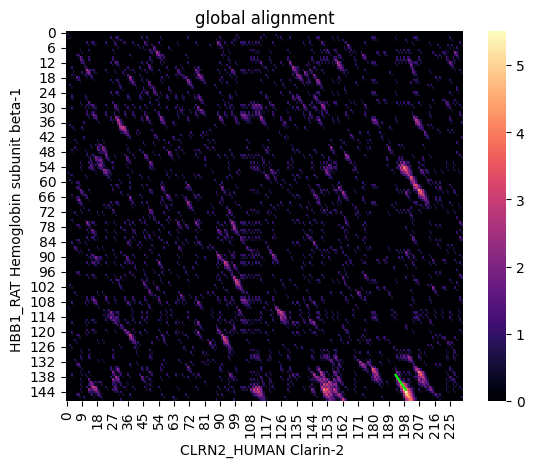

In [13]:
run({"type": "local", "mode1": "fasta", "seq1": "/content/drive/MyDrive/P02091.fasta", "mode2": "fasta", "seq2": "/content/drive/MyDrive/A0PK11.fasta", "bonus": 1, "pen": -.5, "gap": -1, "save_data": True, "filename": "test.txt"})

# Złożoność obliczeniowa

In [14]:
import time
import random

def random_seq(length: int):
    AMINOACIDS = "ARNDCQEGHILKMFPOSUTWYVBZ"
    return "".join([random.choice(AMINOACIDS) for _ in range(length)])

def test_time():
    lens_nw, times_nw = list(), list()
    lens_sw, times_sw = list(), list()
    for n in range(5, 14):
        s1, s2 = random_seq(2 ** n), random_seq(2 ** n)
        start = time.time()
        S, T, ms = needleman_wunsch(s1, s2, 1, 0, -1)
        a1, a2, ba = nw_traceback(s1, s2, T)
        end = time.time()
        lens_nw.append(2 ** n)
        times_nw.append(end - start)
        print(f"Tested NW {n = }, testing took {end - start} s")
        start = time.time()
        S, T, i, j, ms = smith_waterman(s1, s2, 1, -0.5, -1)
        a1, a2, ba = sw_traceback(s1, s2, S, T, i, j)
        end = time.time()
        lens_sw.append(2 ** n)
        times_sw.append(end - start)
        print(f"Tested SW {n = }, testing took {end - start} s")
    return lens_nw, times_nw, lens_sw, times_sw

In [ ]:
ln, tn, ls, ts = test_time()

Tested NW n = 5, testing took 0.003831624984741211 s
Tested SW n = 5, testing took 0.0032958984375 s
Tested NW n = 6, testing took 0.01027822494506836 s
Tested SW n = 6, testing took 0.011230945587158203 s
Tested NW n = 7, testing took 0.0463252067565918 s
Tested SW n = 7, testing took 0.05783581733703613 s
Tested NW n = 8, testing took 0.15679240226745605 s
Tested SW n = 8, testing took 0.1801164150238037 s
Tested NW n = 9, testing took 0.6739945411682129 s
Tested SW n = 9, testing took 0.7937955856323242 s
Tested NW n = 10, testing took 6.145017385482788 s
Tested SW n = 10, testing took 11.343935012817383 s
Tested NW n = 11, testing took 15.989763259887695 s


In [ ]:
retn = np.polyfit(ln, tn, 2)
x = np.arange(0, 2 ** 13, 1)
refn = retn[0] * x ** 2 + retn[1] * x + retn[2]
rets = np.polyfit(ls, ts, 2)
refs = rets[0] * x ** 2 + rets[1] * x + rets[2]

print(f"NW: {retn[0]}x^2 + {retn[1]}x + {retn[2]}")
print(f"SW: {rets[0]}x^2 + {rets[1]}x + {rets[2]}")

plt.plot(ln, tn, marker="o")
plt.plot(x, refn)
plt.plot(ls, ts, marker="o")
plt.plot(x, refs)

plt.xlabel("sequence length")
plt.ylabel("time [s]")

plt.legend(["NW", "NW fit", "SW", "SW fit"])

plt.grid()
plt.show()

Złożoność obliczeniową algorytmu Needlemana-Wunscha można przybliżyć jako:
\begin{equation*}
O(n) = 4.212456313554518\cdot 10^{-6}n^2 -0.0007723472371538136n + 0.05418384600732426
\end{equation*}
a złożoność algorytmu Smitha-Watermana jako:
\begin{equation*}
O(n) = 5.139193604808953\cdot 10^{-6}n^2 + -0.0007964282891110442n + 0.30060685659505376
\end{equation*}